# Load Model

In [ ]:
import os
import sys
sys.path.append('..')

import torch
import pandas as pd

from utils.io import load_yaml, scan2df, natural_keys
from lightning_modules import DeepImageHomographyEstimationModuleBackbone

servers = load_yaml("../config/servers.yml")
server = servers["local"]

# Load model
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print(f"Run on device {device}")

backbone_path = "ae_cai/resnet/48/25/34/version_0"
backbone_path = os.path.join(server["logging"]["location"], backbone_path)
backbone_configs = load_yaml(os.path.join(server["logging"]["location"], backbone_path, "config.yml"))
backbone_configs["model"]["pretrained"] = False  # set to false, as loaded anyways
df = scan2df(os.path.join(server["logging"]["location"], backbone_path, "checkpoints"), ".ckpt")
ckpts = sorted(list(df["file"]), key=natural_keys)

module = DeepImageHomographyEstimationModuleBackbone.load_from_checkpoint(
    checkpoint_path=os.path.join(backbone_path, "checkpoints/{}".format(ckpts[-1])),
    **backbone_configs["model"]
)
module = module.eval().to(device)
module.freeze()

# Load Data

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torch.utils.data import DataLoader
from lightning_modules import DeepImageHomographyEstimationModuleBackbone
from datasets import ImageSequenceDataset
from tqdm import tqdm
from kornia import tensor_to_image
from kornia.geometry import warp_perspective, resize
import PIL
from IPython import display

from utils.processing import frame_pairs, image_edges, four_point_homography_to_matrix, integrate_duv
from utils.viz import yt_alpha_blend#


def cv2_imshow(a):
    r"""A replacement for cv2.imshow() for use in Jupyter notebooks.
    Args:
    a : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
        (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
        image.
    """
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display.display(PIL.Image.fromarray(a))


data_prefix = "cholec80_frames"
in_pkl = "log.pkl"
nth_frame = 20

# Prepare data
data_prefix = os.path.join(server["database"]["location"], data_prefix)
df = pd.read_pickle(os.path.join(data_prefix, in_pkl))

ds = ImageSequenceDataset(
    df, data_prefix, seq_len=2, frame_increment=nth_frame, frames_between_clips=nth_frame
)
ds._df = ds._df.astype(object)
dl = DataLoader(ds, num_workers=0, batch_size=2, drop_last=False, shuffle=False)

# Prepase logging data frame
duv_df = pd.DataFrame({"duv": np.full(len(df), np.nan)})
duv_df = duv_df.astype(object)

for vid, tf_vid, idcs, vid_idcs in tqdm(dl):
    vid = vid.to(device=device, dtype=torch.float)/255.  # without shuffling, average circle detection over whole video

    frames_i, frames_ips = frame_pairs(vid, 1)  # re-sort images
    frames_i   = frames_i.reshape((-1,) + frames_i.shape[-3:])      # reshape BxNxCxHxW -> B*NxCxHxW
    frames_ips = frames_ips.reshape((-1,) + frames_ips.shape[-3:])  # reshape BxNxCxHxW -> B*NxCxHxW

    duvs = module(frames_i, frames_ips)

    # post-process
    uv = image_edges(frames_i)
    H = four_point_homography_to_matrix(uv, -duvs)
    frames_ips_wrp = warp_perspective(frames_i, H, frames_i.shape[-2:])
    frames_ips, frames_ips_wrp = resize(frames_ips, [480, 640]), resize(frames_ips_wrp, [480, 640])

    # visualize
    blend = yt_alpha_blend(frames_ips_wrp[0], frames_ips[0])
    blend = tensor_to_image(blend)

    cv2_imshow(blend*255)
    cv2.waitKey(0)
    

In [6]:
import pandas as pd
labels = pd.read_pickle("/media/martin/Samsung_T5/data/endoscopic_data/cholec80_single_video_frames_cropped/pre_processed_5th_frame_log_new_test_train_labels_no_nan.pkl")
data = pd.read_pickle("/media/martin/Samsung_T5/data/endoscopic_data/cholec80_single_video_frames_cropped/pre_processed_5th_frame_log_new_test_train_no_nan.pkl")

# isolate video
data = data[data.vid == 42]
labels = labels.iloc[data.index]

# offset index
data = data.reset_index(drop=True)
labels = labels.reset_index(drop=True)

# print
print(data)
print(labels)

       folder             file vid  frame  \
0      vid_42      frame_0.npy  42      0   
1      vid_42      frame_1.npy  42      1   
2      vid_42      frame_2.npy  42      2   
3      vid_42      frame_3.npy  42      3   
4      vid_42      frame_4.npy  42      4   
...       ...              ...  ..    ...   
58990  vid_42  frame_58990.npy  42  58990   
58991  vid_42  frame_58991.npy  42  58991   
58992  vid_42  frame_58992.npy  42  58992   
58993  vid_42  frame_58993.npy  42  58993   
58994  vid_42  frame_58994.npy  42  58994   

                                                     duv    duv_mpd  train  
0      [[-31.451099395751953, -28.982019424438477], [...  30.320801   True  
1      [[-31.49654769897461, -25.0295467376709], [2.2...  28.597122   True  
2      [[-24.486557006835938, -14.27912425994873], [2...  20.548455   True  
3      [[-12.914095878601074, -1.9887301921844482], [...   9.058018   True  
4      [[-0.39193326234817505, 8.396044731140137], [-...   7.548171   True

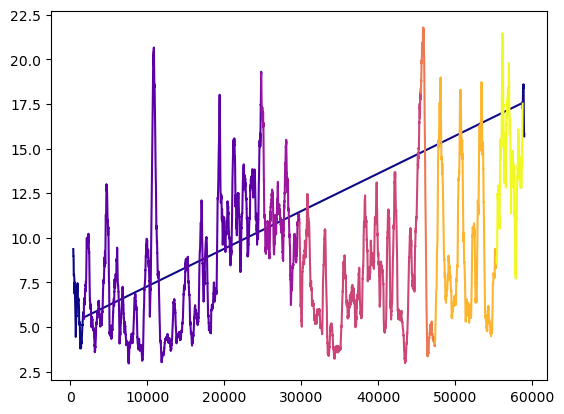

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

cmap = cm.get_cmap("plasma")

phases = labels.Phase.unique().tolist()
colors = {phase: color for phase, color in zip(phases, np.linspace(0, 1, len(phases)))}

# average noise
window = 400
data['duv_mpd_ravg'] = data.duv_mpd.rolling(window).mean()

for phase in colors.keys():
    phase_idx = labels[labels.Phase == phase].index.tolist()
    phase_data = data.iloc[phase_idx]
    plt.plot(phase_idx, phase_data.duv_mpd_ravg, c=cmap(colors[phase]))
plt.show()
